In [1]:
using ADNIDatasets
using Connectomes
using CSV, DataFrames
using DrWatson
using CairoMakie
using Serialization
using Turing
include(projectdir("functions.jl"))

regional_mean (generic function with 2 methods)

In [2]:
# Convenience functions for calculating longitudinal changes
function get_diff(x::Matrix{Float64})
    x[:,end] .- x[:,1]
end
function get_diff(x::Vector{Float64})
    x[end] - x[1]
end
cols = Makie.wong_colors();

In [3]:
include(projectdir("adni/inference/inference-preamble.jl")); # Load data
_abneg_data = ADNIDataset(negdf, dktnames; min_scans=3, reference_region="INFERIORCEREBELLUM", qc=true)
n_subjects = length(_abneg_data)
abneg_mtl_pos = filter(x -> regional_mean(_abneg_data, mtl, x) >= mtl_cutoff, 1:n_subjects)
abneg_neo_pos = filter(x -> regional_mean(_abneg_data, neo, x) >= neo_cutoff, 1:n_subjects)

abneg_tau_pos = findall(x -> x ∈ unique([abneg_mtl_pos; abneg_neo_pos]), 1:n_subjects)
abneg_tau_neg = findall(x -> x ∉ abneg_tau_pos, 1:n_subjects)

abneg_data = _abneg_data[abneg_tau_neg]

subsuvr = calc_suvr.(abneg_data)
_subdata = [normalise(sd, u0, cc) for sd in subsuvr]
blsd = [sd .- u0 for sd in _subdata]

nonzerosubs = findall(x -> sum(x) < 2, [sum(sd, dims=1) .== 0 for sd in blsd]);


In [4]:
_atr_df =  CSV.read(projectdir("adni/data/ucsf-FS-smri.csv"), DataFrame);

In [5]:
function get_atr_df(df, dataset)    
    atr_df = filter(x -> x.RID ∈ get_id.(dataset), df);
    d_idx = findall(x -> x.ID ∈ unique(atr_df.RID), dataset)
    return atr_df, dataset[d_idx], d_idx
end

get_atr_df (generic function with 1 method)

In [6]:
taupos_atr_df, taupos_atr_data, taupos_idx = get_atr_df(_atr_df, pos_data)
tauneg_atr_df, tauneg_atr_data, tauneg_idx = get_atr_df(_atr_df, neg_data)
abneg_atr_df, abneg_atr_data, abneg_idx = get_atr_df(_atr_df, abneg_data[nonzerosubs])

println(length(taupos_atr_data))
println(length(tauneg_atr_data))
println(length(abneg_atr_data))


56
39
51
39
51


In [7]:
function get_vols_icv(atr_df, d)
    _prefix = [fill("CorticalVolume_", 34); fill("SubcorticalVolume_", 2)]
    prefix = [_prefix; _prefix];

    _atr = Vector{Matrix{Float64}}()
    _icv = Vector{Vector{Float64}}()
    for sub in d 
        sub_atr_df = filter(x -> x.RID == sub.ID, atr_df)
        t_idx = [argmin(abs.(sub_atr_df.EXAMDATE .- dt)) for dt in sub.scan_dates]
        push!(_atr, sub_atr_df[t_idx, prefix .* dktnames] |> dropmissing |> Array |> transpose |> Array)
        push!(_icv, sub_atr_df[t_idx, "CorticalVolume_icv"])
    end

    idx = findall(x -> x == 1, size.(_atr, 2) .== length.(_icv))

    println(length(idx))
    atr = _atr[idx]
    icv = _icv[idx]

    _icv_atr = [a ./ i' for (a, i) in zip(atr, icv)]
    icv_atr = [ic ./ ic[:,1] for ic in _icv_atr]

    return atr, icv, icv_atr, d[idx]


end

get_vols_icv (generic function with 1 method)

In [8]:
taupos_atr, taupos_icv, taupos_atr_icv, taupos_atr_icv_data = get_vols_icv(taupos_atr_df, taupos_atr_data)
tauneg_atr, tauneg_icv, tauneg_atr_icv, tauneg_atr_icv_data = get_vols_icv(tauneg_atr_df, tauneg_atr_data)
abneg_atr, abneg_icv, abneg_atr_icv, abneg_atr_icv_data = get_vols_icv(abneg_atr_df, abneg_atr_data);

54
39
51
39
51


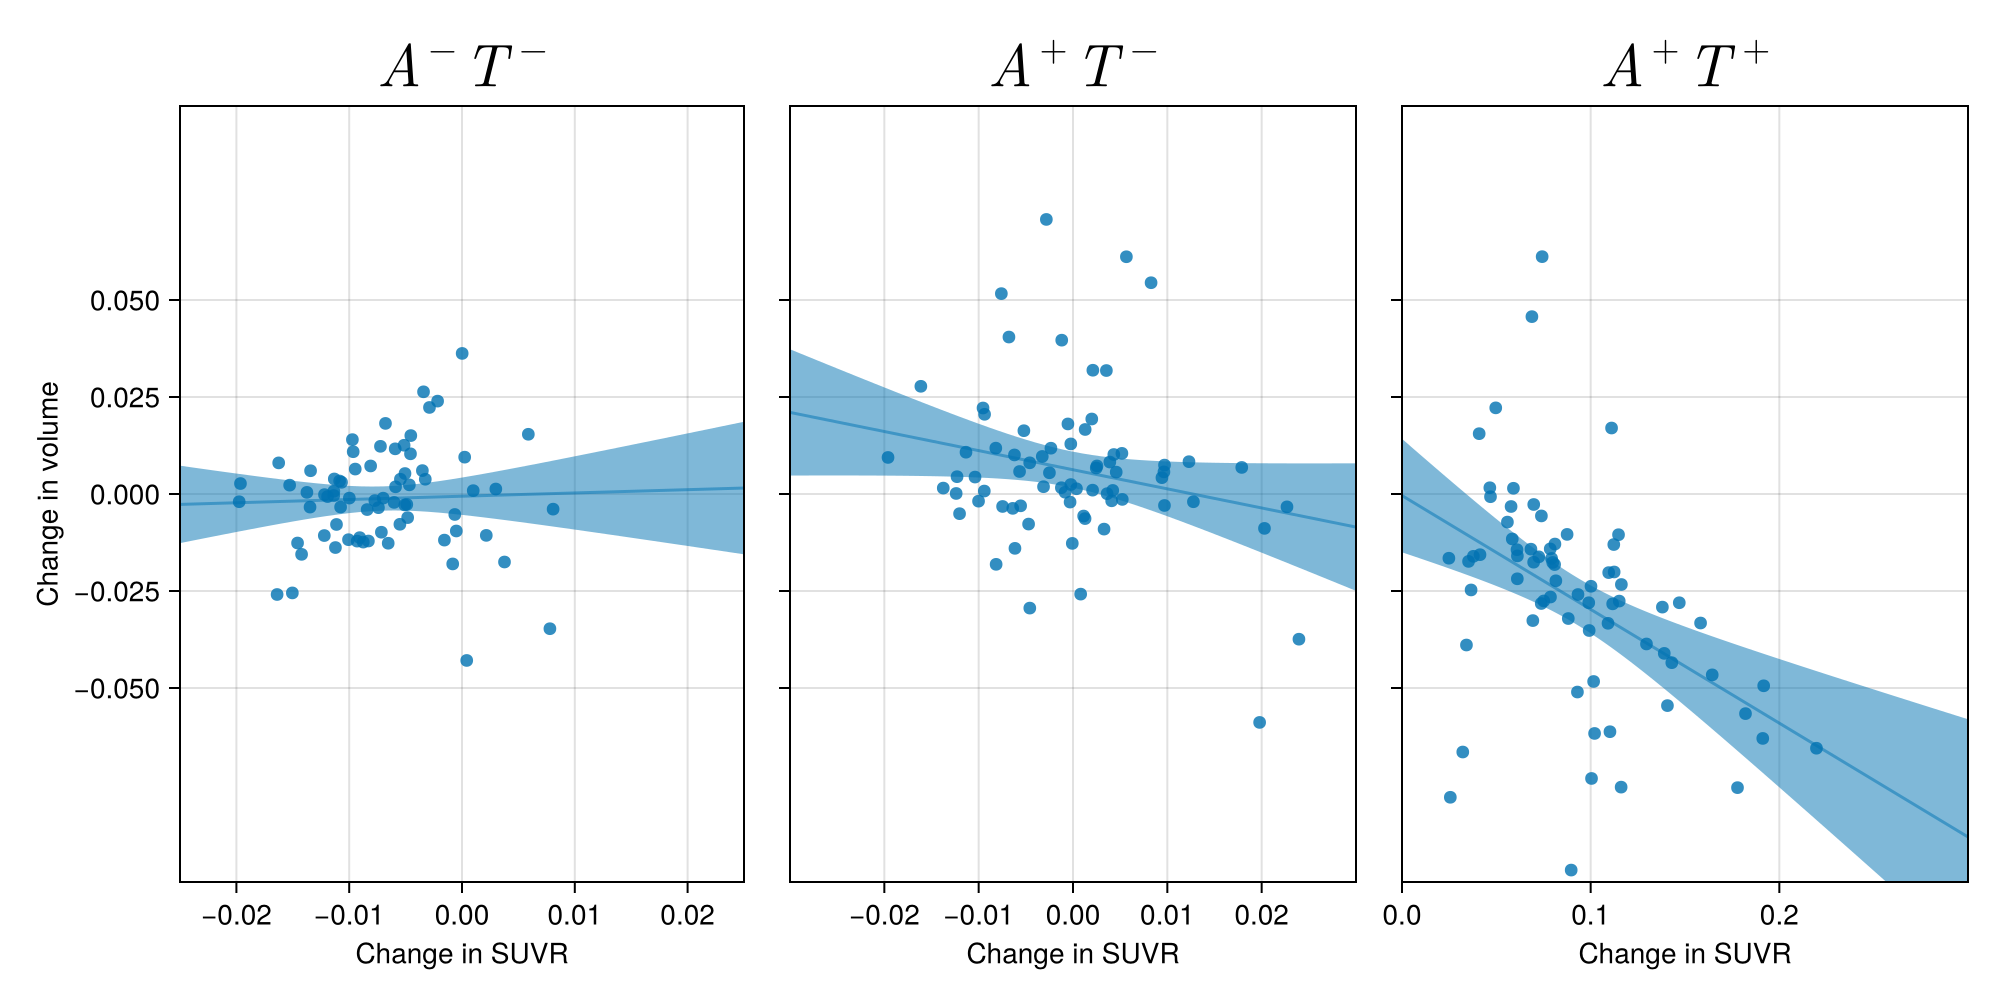

In [9]:
using GLM 

f = Figure(size=(1000, 500))


for (i, (d, atr, label, lim)) in enumerate(zip(reverse([taupos_atr_icv_data, tauneg_atr_icv_data, abneg_atr_icv_data]), 
                                          reverse([taupos_atr_icv, tauneg_atr_icv, abneg_atr_icv]),
                                          reverse([L"A^+T^+",L"A^+T^-",L"A^-T^-"]), 
                                          [[-0.025, 0.025], [-0.03, 0.03], [-0., 0.3]]))
    
    ax = Axis(f[1,i], title=label, titlesize=30, ylabel="Change in volume", xlabel="Change in SUVR", yticks=-0.05:0.025:0.05)
    ylims!(ax, -0.1, 0.1)
    xlims!(ax, lim[1], lim[2])
    if i > 1
        hideydecorations!(ax, grid=false, ticks=false)
    end
    subsuvr = calc_suvr.(d)
    subdata = [normalise(sd, u0, cc) for sd in subsuvr]


    df = DataFrame(d = vec(mean(reduce(hcat, get_diff.(subdata)), dims=2)), v = vec(mean(reduce(hcat, get_diff.(atr)), dims=2)))

    ols = lm(@formula(v ~ d), df)
    pred = predict(ols, df)

    tdf = DataFrame(d = lim[1]:0.001:lim[2])
    pred = predict(ols, tdf, interval = :confidence, level = 0.95) |> dropmissing

    # f = scatter(vec(mean(reduce(hcat, get_diff.(subdata)), dims=2)), vec(mean(reduce(hcat, get_diff.(vols)), dims=2)), color=(cols[3], 0.8),)
    scatter!(ax, df.d, df.v, color=(cols[1], 0.8),)
    lines!(ax, tdf.d, pred.prediction, color=(cols[1], 0.5))
    band!(ax, tdf.d, pred.lower, pred.upper, color=(cols[1], 0.5))
end
f

In [10]:
function get_thickness(atr_df, d, c_idx)
    prefix = fill("ThicknessAverage_", 68)

    _atr = Vector{Matrix{Float64}}()
    for sub in d 
        sub_atr_df = filter(x -> x.RID == sub.ID, atr_df)
        t_idx = [argmin(abs.(sub_atr_df.EXAMDATE .- dt)) for dt in sub.scan_dates]
        push!(_atr, sub_atr_df[t_idx, prefix .* dktnames[c_idx]] |> dropmissing |> Array |> transpose |> Array)
    end

    idx = findall(x -> x == 1, size.(_atr, 2) .== length.(d))
    println(length(idx))

    atr = _atr[idx]

    return atr, d[idx]


end

get_thickness (generic function with 1 method)

In [11]:
c_idx = findall(x -> get_cortex(x) == "cortical", cortex);


In [19]:
taupos_thickness, taupos_thickness_data = get_thickness(taupos_atr_df, taupos_atr_data, c_idx)
tauneg_thickness, tauneg_thickness_data = get_thickness(tauneg_atr_df, tauneg_atr_data, c_idx)
abneg_thickness, abneg_thickness_data = get_thickness(abneg_atr_df, abneg_atr_data, c_idx);

54
39
51
39
51


In [23]:
noec = setdiff(1:1:68, [27, 61])

66-element Vector{Int64}:
  1
  2
  3
  4
  5
  6
  7
  8
  9
 10
  ⋮
 59
 60
 62
 63
 64
 65
 66
 67
 68

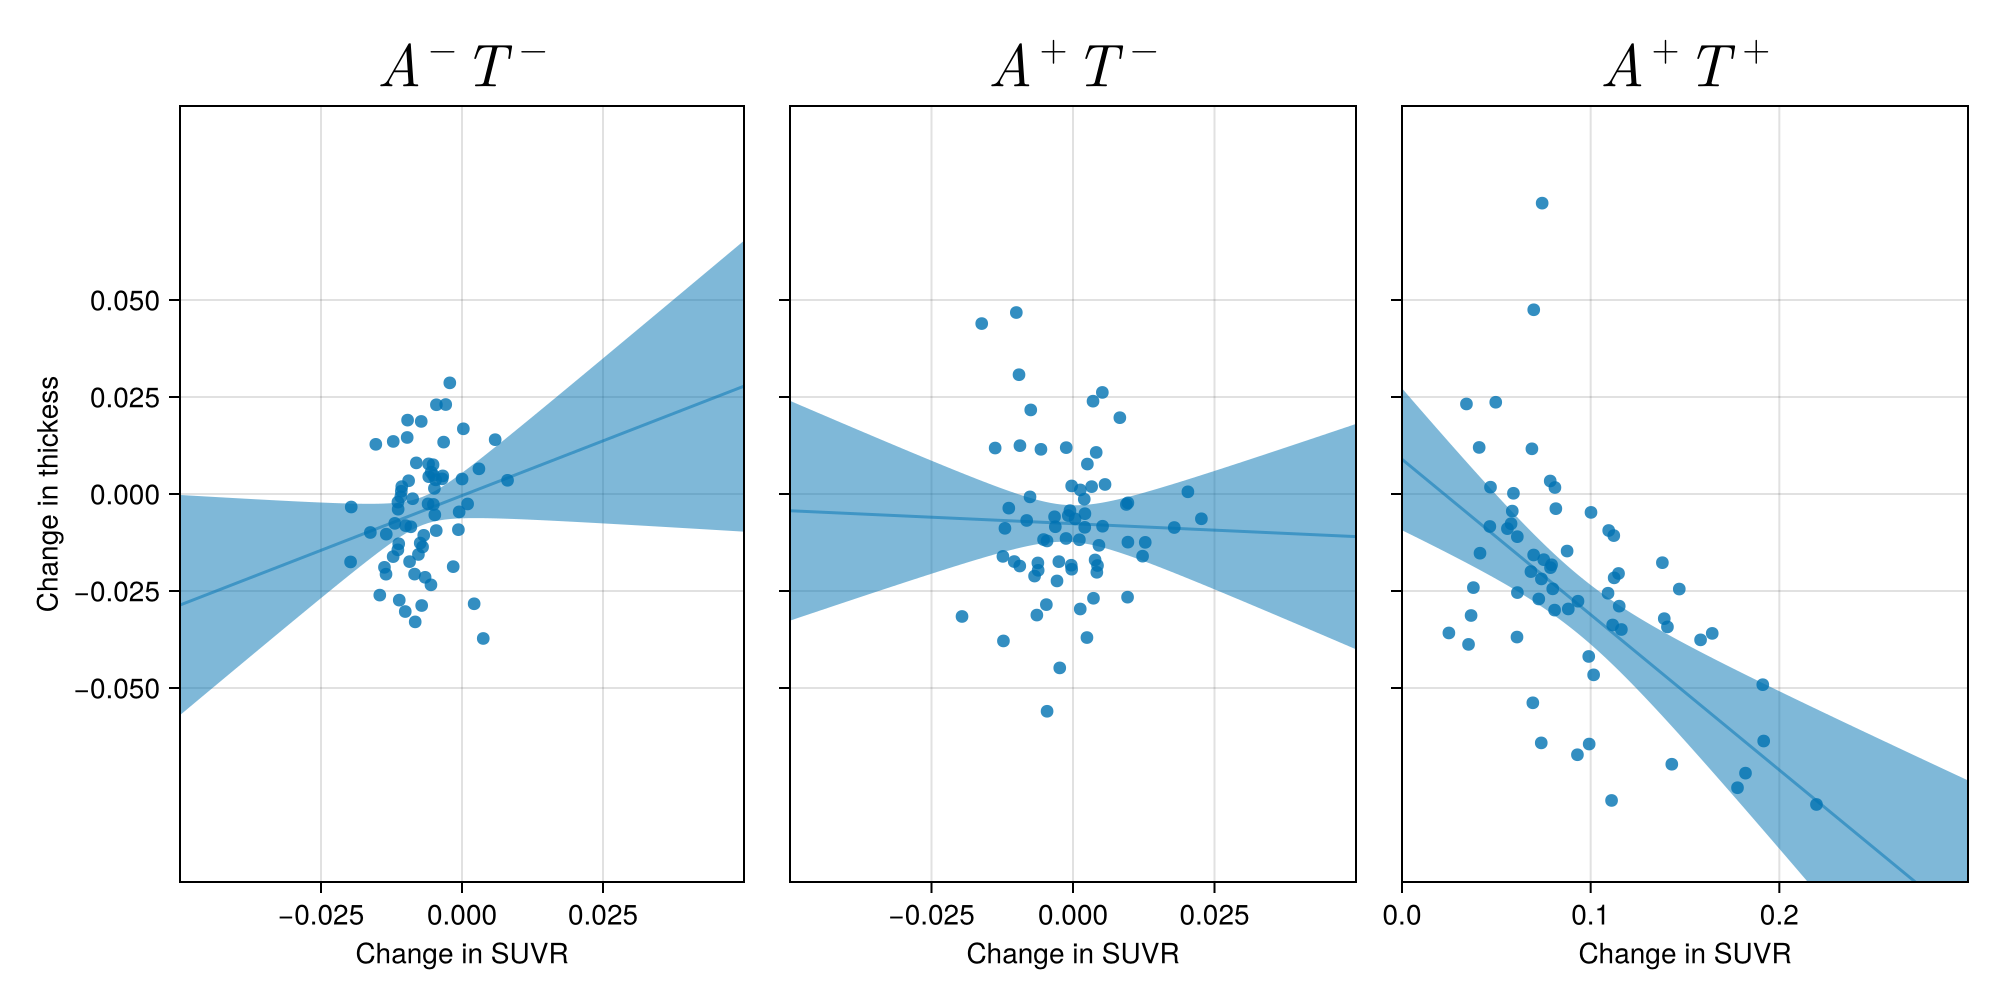

In [25]:
using GLM 

f = Figure(size=(1000, 500))


for (i, (d, atr, label, lim)) in enumerate(zip(reverse([taupos_thickness_data, tauneg_thickness_data, abneg_thickness_data]), 
                                          reverse([taupos_thickness, tauneg_thickness, abneg_thickness]),
                                          reverse([L"A^+T^+",L"A^+T^-",L"A^-T^-"]), 
                                          [[-0.05, 0.05], [-0.05, 0.05], [-0., 0.3]]))
    
    ax = Axis(f[1,i], title=label, titlesize=30, ylabel="Change in thickess", xlabel="Change in SUVR", yticks=-0.05:0.025:0.05)
    ylims!(ax, -0.1, 0.1)
    xlims!(ax, lim[1], lim[2])
    if i > 1
        hideydecorations!(ax, grid=false, ticks=false)
    end
    subsuvr = calc_suvr.(d)
    subdata = [normalise(sd[c_idx,:], u0[c_idx], cc[c_idx]) for sd in subsuvr]

    df = DataFrame(d = vec(mean(reduce(hcat, get_diff.(subdata)), dims=2))[noec], v = vec(mean(reduce(hcat, get_diff.(atr)), dims=2))[noec])

    ols = lm(@formula(v ~ d), df)
    pred = predict(ols, df)

    tdf = DataFrame(d = lim[1]:0.001:lim[2])
    pred = predict(ols, tdf, interval = :confidence, level = 0.95) |> dropmissing

    # f = scatter(vec(mean(reduce(hcat, get_diff.(subdata)), dims=2)), vec(mean(reduce(hcat, get_diff.(vols)), dims=2)), color=(cols[3], 0.8),)
    scatter!(ax, df.d, df.v, color=(cols[1], 0.8),)
    lines!(ax, tdf.d, pred.prediction, color=(cols[1], 0.5))
    band!(ax, tdf.d, pred.lower, pred.upper, color=(cols[1], 0.5))
end
save(projectdir("visualisation/thickness-vs-suvr.pdf"), f)
f

In [27]:
pst = deserialize(projectdir("adni/new-chains/local-fkpp/length-free/pst-abneg-4x2000.jls"));
meanpst = mean(pst);

as = [meanpst["α[$i]", :mean] for i in abneg_idx]

51-element Vector{Float64}:
 -0.08486879839356778
 -0.03315275445546298
 -0.05821498979797103
 -0.022709158541436375
 -0.4544959340159816
 -0.350489045640468
  0.12989049854636858
 -0.042745801775801374
 -0.0734012746548439
  0.02146574719675367
  ⋮
  0.08281423119187481
  0.02908170345234997
  0.03625740812383613
  0.0679593389470304
 -0.0837309488539086
  0.013958575051000543
 -0.04213857986612242
 -0.1215377320106179
  0.3277227310863121

In [28]:
[a[noec, :] for a in abneg_thickness]

51-element Vector{Matrix{Float64}}:
 [2.651 2.65 2.758; 2.883 2.904 2.872; … ; 2.473 2.458 2.464; 2.88 2.8 2.87]
 [2.483 2.576 2.548; 2.511 2.541 2.452; … ; 1.975 1.917 1.927; 2.747 2.854 2.841]
 [2.63 2.487 2.396; 2.659 2.653 2.634; … ; 2.338 2.475 2.398; 2.939 2.893 2.918]
 [2.496 2.586 … 2.523 2.521; 2.656 2.668 … 2.545 2.483; … ; 2.342 2.205 … 2.242 2.213; 2.825 2.805 … 2.828 2.99]
 [2.678 2.678 2.699; 2.649 2.649 2.74; … ; 2.074 2.074 2.232; 3.037 3.037 2.999]
 [2.448 2.427 2.51 2.49; 2.537 2.621 2.579 2.6; … ; 2.09 2.337 2.218 2.231; 2.953 2.814 2.744 2.793]
 [2.457 2.416 2.373 2.378; 2.388 2.422 2.362 2.392; … ; 2.278 2.269 2.262 2.249; 2.836 2.817 2.842 2.804]
 [2.517 2.603 2.468; 2.539 2.569 2.554; … ; 2.394 2.435 2.462; 2.873 2.921 2.81]
 [2.612 2.562 2.579; 2.682 2.597 2.682; … ; 2.37 2.399 2.266; 2.901 2.847 2.933]
 [2.698 2.608 2.682; 2.558 2.474 2.622; … ; 2.111 2.222 2.229; 2.829 2.885 2.913]
 ⋮
 [2.452 2.474 2.378; 2.62 2.623 2.699; … ; 2.19 2.262 2.271; 2.861 2.88 2.84

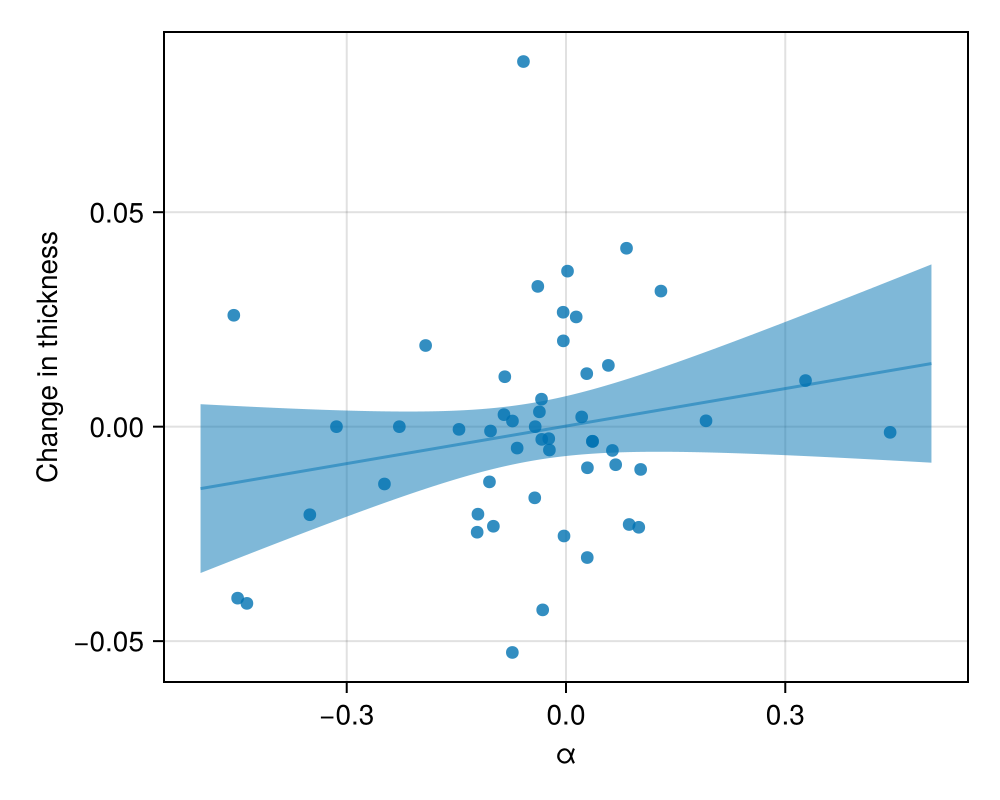

In [32]:

df = DataFrame(d = as, v = vec(mean(reduce(hcat, get_diff.(abneg_atr_icv)), dims=1)))

ols = lm(@formula(v ~ d), df)
pred = predict(ols, df)

tdf = DataFrame(d = -0.5:0.001:0.5)
pred = predict(ols, tdf, interval = :confidence, level = 0.95) |> dropmissing

# f = scatter(vec(mean(reduce(hcat, get_diff.(subdata)), dims=2)), vec(mean(reduce(hcat, get_diff.(vols)), dims=2)), color=(cols[3], 0.8),)
f = Figure(size=(500, 400))
ax = Axis(f[1,1], xlabel="α", ylabel="Change in thickness")
scatter!(df.d, df.v, color=(cols[1], 0.8),)
lines!(tdf.d, pred.prediction, color=(cols[1], 0.5))
band!(tdf.d, pred.lower, pred.upper, color=(cols[1], 0.5))
save(projectdir("visualisation/thickness-vs-alpha.pdf"), f)
f

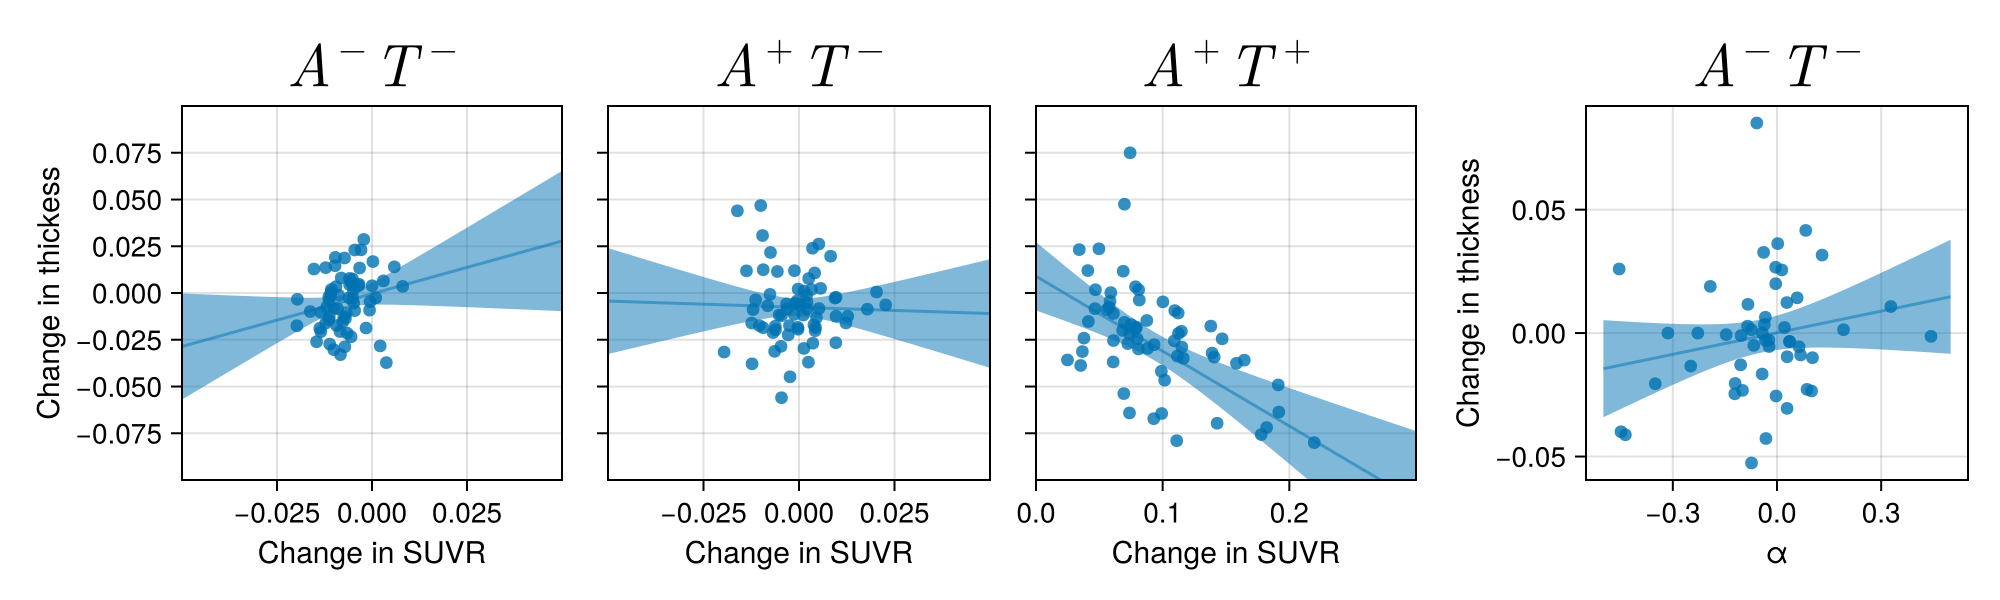

In [43]:
using GLM 

f = Figure(size=(1000, 300))


for (i, (d, atr, label, lim)) in enumerate(zip(reverse([taupos_thickness_data, tauneg_thickness_data, abneg_thickness_data]), 
                                          reverse([taupos_thickness, tauneg_thickness, abneg_thickness]),
                                          reverse([L"A^+T^+",L"A^+T^-",L"A^-T^-"]), 
                                          [[-0.05, 0.05], [-0.05, 0.05], [-0., 0.3]]))
    
    ax = Axis(f[1,i], title=label, titlesize=30, ylabel="Change in thickess", xlabel="Change in SUVR", xlabelsize=15, ylabelsize=15, yticks=-0.075:0.025:0.075)
    ylims!(ax, -0.1, 0.1)
    xlims!(ax, lim[1], lim[2])
    if i > 1
        hideydecorations!(ax, grid=false, ticks=false)
    end
    subsuvr = calc_suvr.(d)
    subdata = [normalise(sd[c_idx,:], u0[c_idx], cc[c_idx]) for sd in subsuvr]

    df = DataFrame(d = vec(mean(reduce(hcat, get_diff.(subdata)), dims=2))[noec], v = vec(mean(reduce(hcat, get_diff.(atr)), dims=2))[noec])

    ols = lm(@formula(v ~ d), df)
    pred = predict(ols, df)

    tdf = DataFrame(d = lim[1]:0.001:lim[2])
    pred = predict(ols, tdf, interval = :confidence, level = 0.95) |> dropmissing

    # f = scatter(vec(mean(reduce(hcat, get_diff.(subdata)), dims=2)), vec(mean(reduce(hcat, get_diff.(vols)), dims=2)), color=(cols[3], 0.8),)
    scatter!(ax, df.d, df.v, color=(cols[1], 0.8),)
    lines!(ax, tdf.d, pred.prediction, color=(cols[1], 0.5))
    band!(ax, tdf.d, pred.lower, pred.upper, color=(cols[1], 0.5))
end

df = DataFrame(d = as, v = vec(mean(reduce(hcat, get_diff.(abneg_atr_icv)), dims=1)))

ols = lm(@formula(v ~ d), df)
pred = predict(ols, df)

tdf = DataFrame(d = -0.5:0.001:0.5)
pred = predict(ols, tdf, interval = :confidence, level = 0.95) |> dropmissing

ax = Axis(f[1,4], xlabel="α", ylabel="Change in thickness", xlabelsize=15, ylabelsize=15, title=L"A^-T^-", titlesize=30)
scatter!(df.d, df.v, color=(cols[1], 0.8),)

lines!(tdf.d, pred.prediction, color=(cols[1], 0.5))
band!(tdf.d, pred.lower, pred.upper, color=(cols[1], 0.5))
save(projectdir("visualisation/thickness-vs-suvr-alpha.pdf"), f)
f